# Environment Setup

Set up LangChain environment variables for tracing and project configuration

In [1]:
import os

os.environ["LANGCHAIN_PROJECT"] = "interviewer"
os.environ["LANGCHAIN_API_KEY"] = "YOUR_API_KEY"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_TRACING"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

# Imports and Initialization

In [2]:
# Import modules and type helpers
import json, random
from typing import Annotated, List, Literal
from typing_extensions import TypedDict

# LangChain-specific components
from langchain.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.types import Command, interrupt

# Memory Checkpointing
Using in-memory checkpointing for LangGraph execution

In [3]:
from langgraph.checkpoint.memory import MemorySaver


memory = MemorySaver()

# Speech-to-Text (STT) Setup
Loading STT implemented using using VAD (webrtcvad) and local whisper model

In [4]:
from stt import STT


stt = STT(
    vad_mode=3,
    whisper_model="small", 
)

# Text-to-Speech (TTS) Steup
Converting text to speech using gTTS and playing it using pygame

In [5]:
import io
import pygame
from gtts import gTTS


def speak_text(text: str):
    tts = gTTS(text)
    mp3_fp = io.BytesIO()
    tts.write_to_fp(mp3_fp)

    pygame.mixer.init()
    mp3_fp.seek(0)
    pygame.mixer.music.load(mp3_fp)
    pygame.mixer.music.play()

    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

pygame 2.6.1 (SDL 2.28.4, Python 3.11.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


# PDF Resume Parsing
Loads and extracts text from each page of the given resume PDF

In [6]:
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader


def get_resume_text(file_path):
    loader = PyPDFLoader(file_path)
    pages: List[Document] = []
    for page in loader.lazy_load():
        pages.append(page)
    return "\n\n".join(page.page_content for page in pages)

# Schema Definitions using Pydantic
Enums and Pydantic models for structured resume and interview information

In [7]:
from enum import Enum
from typing import Optional
from pydantic import BaseModel, Field


class SkillLevel(Enum):
    """Skill proficiency levels"""
    BEGINNER = 1
    BASIC = 2
    INTERMEDIATE = 3
    ADVANCED = 4
    EXPERT = 5


class Skill(BaseModel):
    """Represents a skill with a name and proficiency level"""
    name: str = Field(..., description="The name of the skill (e.g., Python, JavaScript)")
    level: Optional[SkillLevel] = Field(None, description="The proficiency level of the skill")


class Project(BaseModel):
    """Represents a project with its name, description, and tech stack"""
    name: str = Field(..., description="The name of the project")
    description: str = Field(..., description="A short description of the project")
    tech_stack: Optional[List[str]] = Field(None, description="List of technologies used in the project")


class Experience(BaseModel):
    """Represents a work experience entry"""
    org_name: str = Field(..., description="The name of the organization or company")
    description: List[str] = Field(..., description="List of responsibilities or achievements")


class Education(BaseModel):
    """Represents an educational qualification"""
    institution: str = Field(..., description="The name of the educational institution")
    degree: str = Field(..., description="The degree or qualification earned")
    graduation_year: Optional[str] = Field(None, description="The year of graduation")


class Resume(BaseModel):
    """Represents a job candidate's resume"""
    name: str = Field(..., description="The candidate's full name")
    email: Optional[str] = Field(None, description="The candidate's email address")
    phone_number: Optional[str] = Field(None, description="The candidate's phone number")
    location: Optional[str] = Field(None, description="The candidate's location (city, country)")
    total_experience: Optional[str] = Field(None, description="Total years of work experience")
    education: List[Education] = Field(..., description="List of educational qualifications")
    skills: List[Skill] = Field(..., description="List of skills with proficiency levels")
    work_experience: List[Experience] = Field(..., description="List of previous work experiences")
    certifications: Optional[List[str]] = Field(None, description="List of professional certifications")
    projects: Optional[List[Project]] = Field(None, description="List of notable projects")
    summary: str = Field(..., description="A short professional summary (1-2 lines)")


class FeedbackResponse(BaseModel):
    """Represents the evaluation result of a candidate's answer to a technical interview question."""
    feedback_summary: str = Field(..., description="A brief explanation of what was good and what can be improved.")
    score: int = Field(..., description="Score from 0 to 10 evaluating the quality of the answer.")
    response_for_user: str = Field(..., description="The response to be given to the candidate.")
    followup_question: Optional[str] = Field(None, description="Any follow up question to be given to the candidate. (Optional)")

# State Data Structures for Interview
State tracking classes to manage tags, questions, answers, and interview flow

In [8]:
class CurrentTagData(BaseModel):
    index: int
    tag: str
    num_questions: int


class InterviewData(BaseModel):
    question: str
    answer: str
    feedback: FeedbackResponse


class InterviewState(TypedDict):
    resume_text: str
    parsed_resume: Resume
    current_question: str
    questions_asked: List[str]
    tags: List[str]
    current_tag_data: CurrentTagData
    last_answer: str
    feedback: FeedbackResponse
    interview_data: List[InterviewData]
    messages: Annotated[list, add_messages]
    finished: bool

# Node: Resume Parsing
Parses resume text into structured Resume object using LLM

In [9]:
def parse_resume(state: InterviewState) -> Command[Literal["generate_question"]]:
    resume_text = state.get("resume_text", "")
    prompt = ChatPromptTemplate([
        ("system", "You are an expert resume parser. Given a plain text resume, extract structured information in JSON format."),
        ("human", "resume text: {resume_text}")
    ])
    llm = init_chat_model(model="gpt-4o-mini", model_provider="openai")
    resume_parser_llm = llm.with_structured_output(Resume)
    chain = prompt | resume_parser_llm
    parsed_resume = chain.invoke({"resume_text": resume_text})
    return Command(
        update={
            "parsed_resume": parsed_resume,
            "messages": [{"name": "parse_resume", "role": "ai", "content": json.dumps(parsed_resume.model_dump_json())}],
        },
        goto="generate_question",
        # graph=Command.PARENT
    )

# Helper: Tag Selection Logic
Determines the current tag and check whether to move to the next tag

In [10]:
def get_tag(state: InterviewState, min_questions_per_tag=2, max_questions_per_tag=5) -> Optional[CurrentTagData]:
    tags = state.get("tags", [])
    
    default_current_tag_data = CurrentTagData(
        index=0, 
        tag=tags[0], 
        num_questions=0
    )
    
    current_tag_data = state.get("current_tag_data", default_current_tag_data)
    
    index = current_tag_data.index
    num_questions = current_tag_data.num_questions
    if num_questions >= random.randint(min_questions_per_tag, max_questions_per_tag):
        if index == len(tags) - 1:
            return None
        current_tag_data = CurrentTagData(
            index=index + 1, 
            tag=tags[index + 1], 
            num_questions=0
        )
    return current_tag_data

# Node: Generate Interview Question
Asks a tag-specific, non-repeating question using LLM

In [11]:
def generate_question(state: InterviewState) -> Command[Literal["get_user_answer", "__end__"]]:
    parsed_resume = state.get("parsed_resume")
    questions_asked = state.get("questions_asked", [])
    questions_asked = [f"{i + 1}. {questions_asked[i]}" for i in range(len(questions_asked))]
    tag = get_tag(state, 2, 5)
    if tag is None:
        # all questions over
        return Command(
            update={"finished": True},
            goto="__end__"
        )
    
    prompt = ChatPromptTemplate([
        ("system", "You are an expert technical interviewer. Your task is to evaluate a candidate's resume, and a tag, and then ask the most relevant question. Your question must be short and crisp and not be repeated from previously asked questions."),
        ("human", "tag: {tag}\n\nresume: {resume}\n\npreviously asked questions: {questions_asked}"),
    ])
    llm = init_chat_model(model="gpt-4o-mini", model_provider="openai")
    chain = prompt | llm | StrOutputParser()
    question = chain.invoke({
        "tag": tag.tag, 
        "resume": parsed_resume.model_dump_json(),
        "questions_asked": "\n".join(questions_asked),
    })

    speak_text(question)
    
    return Command(
        update={
            "current_tag_data": tag,
            "current_question": question,
            "messages": [{"name": "generate_question", "role": "ai", "content": question}],
        },
        goto="get_user_answer",
        # graph=Command.PARENT
    )

# Node: Capture User Answer
Uses interrupt to wait for user answer input

In [12]:
def get_user_answer(state: InterviewState) -> Command[Literal["evaluate_answer"]]:
    current_question = state.get("current_question", "")
    questions_asked = state.get("questions_asked", [])
    questions_asked = [f"{i + 1}. {questions_asked[i]}" for i in range(len(questions_asked))]
    current_tag_data = state.get("current_tag_data")
    current_tag_data.num_questions += 1
    user_response = interrupt({"question": current_question, "invoked_from": "get_user_answer"})
    questions_asked.append(current_question)
    return Command(
        update={
            "last_answer": user_response["answer"],
            "questions_asked": questions_asked,
            "current_tag_data": current_tag_data,
            "messages": [{"name": "get_user_answer", "role": "user", "content": user_response["answer"]}],
        },
        goto="evaluate_answer",
        # graph=Command.PARENT
    )

# Node: Evaluate Answer
Uses LLM to evaluate user answer, gives score and optional follow-up

In [13]:
def evaluate_answer(state: InterviewState) -> Command[Literal["feedback_and_followups"]]:
    question = state.get("current_question")
    answer = state.get("last_answer", "")
    questions_asked = state.get("questions_asked", [])
    interview_data = state.get("interview_data", [])
    prompt = ChatPromptTemplate([
        ("system", "You are a professional technical interviewer. Your task is to fairly and accurately evaluate a candidate's answer to a technical interview question and also give a response to the candidate. If the candidate answer is empty, give them 0 score and a helping feedback. Only ask a follow-up question if it is essential for evaluating the candidate's understanding further. otherwise don't ask. Make sure if you ask a follow up question, it should not have been asked previously."),
        ("human", "Question: {question}\nAnswer: {answer}\nPrevious Questions: {questions_asked}")
    ])

    llm = init_chat_model(model="gpt-4o-mini", model_provider="openai")
    feedback_llm = llm.with_structured_output(FeedbackResponse)
    chain = prompt | feedback_llm
    feedback_response = chain.invoke({
        "question": question, 
        "answer": answer, 
        "questions_asked": "\n".join(questions_asked),
    })
    interview_data.append(InterviewData(
        question = question,
        answer = answer,
        feedback = feedback_response
    ))
    return Command(
        update={
            "feedback": feedback_response,
            "interview_data": interview_data,
            "messages": [{"name": "evaluate_answer", "role": "ai", "content": json.dumps(feedback_response.model_dump_json())}],
        },
        goto="feedback_and_followups",
        # graph=Command.PARENT
    )

# Node: Provide Feedback and Handle Follow-Ups
Speaks feedback to user and check if follow-up is needed

In [14]:
def feedback_and_followups(state: InterviewState) -> Command[Literal["generate_question", "get_user_answer"]]:
    feedback_response = state.get("feedback")
    speak_text(feedback_response.response_for_user)

    if feedback_response.followup_question is not None:
        # Ask follow-up immediately
        speak_text(feedback_response.followup_question)
        return Command(
            update={
                "current_question": feedback_response.followup_question,
                "messages": [{"name": "followup_question", "role": "ai", "content": feedback_response.followup_question}],
            },
            goto="get_user_answer"
            # graph=Command.PARENT
        )

    return Command(
        goto="generate_question"
        # graph=Command.PARENT
    )

# Graph Construction
Constructing LangGraph by adding nodes

In [15]:
graph = StateGraph(InterviewState)
graph.add_node("parse_resume", parse_resume)
graph.add_node("generate_question", generate_question)
graph.add_node("get_user_answer", get_user_answer)
graph.add_node("evaluate_answer", evaluate_answer)
graph.add_node("feedback_and_followups", feedback_and_followups)

graph.set_entry_point("parse_resume")

In [16]:
app = graph.compile(checkpointer=memory)

# Graph Visualization
Displaying the visual representation of the interview process graph

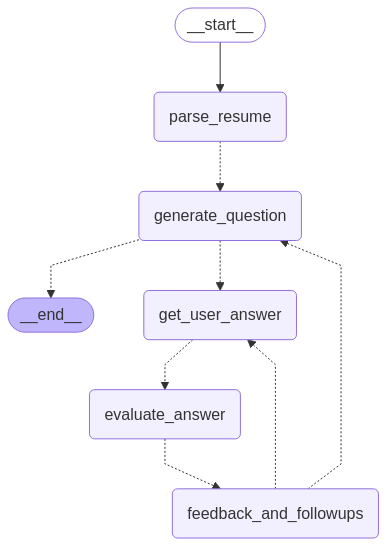

In [17]:
from IPython.display import Image, display


display(Image(app.get_graph().draw_mermaid_png()))

# Signal Handling
Allows graceful shutdown of threads (Ctrl+C)

In [18]:
import signal
import threading


# Global shutdown event
shutdown_event = threading.Event()


def signal_handler(sig, frame):
    print("\nCtrl+C detected. Shutting down...")
    shutdown_event.set()  # Signaling all threads to stop


# Registering signal handler
signal.signal(signal.SIGINT, signal_handler)

<function _signal.default_int_handler(signalnum, frame, /)>

# Interview Score Calculation
Calculates total interview score along with percentage

In [19]:
def get_score(interview_data: List[InterviewData]):
    score = 0
    max_score = len(interview_data) * 10
    for idata in interview_data:
        score += idata.feedback.score
    percentage = (score / max_score) * 100
    return score, max_score, percentage

# Main Function to start an interview

In [20]:
def run_interview(resume_file_path, tags, thread_id="default"):
    # Extracting text from the provided resume file
    resume_text = get_resume_text(resume_file_path)
    initial_state: InterviewState = {
        'resume_text': resume_text,
        'tags': tags,
        'questions_asked': [],
        'messages': [{"name": "user", "role": "user", "content": f"tags: {tags}\n\nresume text: {resume_text}"}]
    }

    config = {"configurable": {"thread_id": thread_id}, "recursion_limit": 25}
    # Starting stream of interview events from the LangGraph app
    events = app.stream(initial_state, config, stream_mode="values")


    try:
        # Main event processing loop, runs until shutdown is triggered
        while not shutdown_event.is_set():
            for event in events:

                # Printing the last user/AI message if available
                if "messages" in event:
                    messages = event["messages"]
                    last_message = messages[-1]
                    print(f"\n{last_message.pretty_print()}")
                else:
                    # Logging any other kind of event (for debugging)
                    print("logging my event here: ", event)

                # If this message is from get_user_answer node, we need to interrupt, get user's input and then continue
                if "__interrupt__" in event:
                    interrupt = event["__interrupt__"][0]
                    interrupt_node = interrupt.ns[0].split(":")[0]
                    if interrupt_node == "get_user_answer":
                        # Capture and process user's voice answer
                        user_transcript = stt.run()
                        human_command = Command(resume={"answer": " ".join(user_transcript)})
                        # Resume streaming with user's answer
                        events = app.stream(human_command, config, stream_mode="values")
                        break  # breaking from inner for loop to process next cycle
                # Handling interview completion event
                if "finished" in event and event["finished"] == True:
                    # calculating and announcing the final score
                    speak_text("Your interview is now complete")
                    if "interview_data" in event and event["interview_data"] is not None and len(event["interview_data"]) > 0:
                        score, max_score, percentage = get_score(event["interview_data"])
                        speak_text(f"Your final interview score is {score} out of {max_score}, which is {percentage}%")
                    return # Exiting the function after completion
    except KeyboardInterrupt:
        # Allows graceful shutdown with Ctrl+C (sets shutdown event)
        shutdown_event.set()  # Redundant but safe

In [21]:
pdf_path = "/Users/parth/Development/ai/interviewer/resumes/Parth Singh - Resume.pdf"
# tags = ["Generative AI", "Python", "Software Development"]
tags = ["Python"]

run_interview(resume_file_path=pdf_path, tags=tags, thread_id="8")

================================ Human Message =================================
Name: user

tags: ['Python']

resume text: Parth Singh
Experienced Software Developer
♂¶obile+91 9997114215 /envel⌢peparth.singh71@gmail.com /h⌢meNoida, UP, India
/linkedinin/parthsingh71 /githubgithub.com/parth-singh71 /codeleetcode/parthsingh71
Profile
Experienced software developer skilled in Python, Generative AI, Agentic AI, LangChain, LangGraph, Backend,
RESTful API development, Django and Django REST Frameworkwith a strong understanding of software development
principles and best practices.
Professional Experience
AI Software Engineer, Simbo Inc. Bengaluru, India (Remote) 06/2021 - present
• Developed an LLM-based intent detection system with integrated sentiment analysis and response suggestion for specific
intents, serving as a fallback mechanism for the NLP variant.
• Built and deployed complex LLM chains using GPT-3, GPT-4, LLaMA 2, Claude v2.1, and Command LLM within Python
pipelines to generat

/Users/parth/Development/ai/interviewer/.env/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Silence: 2 sec
2
Silence: 3 sec
3
Transcript: I'm not sure if this is to be spent here because it is against me policy
Silence: 4 sec
4
Silence: 5 sec
Silence for 5 seconds. Stopping...
================================== Ai Message ==================================
Name: generate_question

Can you explain how you handled performance optimization in your LLM-based intent detection system?

None
================================ Human Message =================================
Name: get_user_answer

I'm not sure if this is to be spent here because it is against me policy

None
================================== Ai Message ==================================
Name: evaluate_answer

"{\"feedback_summary\":\"Your response was empty, which indicates a lack of insight into the topic. It would be beneficial to provide examples or methods you've used for performance optimization in LLM-based systems. Consider discussing techniques like model pruning, quantization, or using faster architectures.\",

/Users/parth/Development/ai/interviewer/.env/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Silence: 2 sec
2
Silence: 3 sec
3
Transcript: I used JWT application for securing my APIs.
Silence: 4 sec
4
Silence: 5 sec
Silence for 5 seconds. Stopping...
================================== Ai Message ==================================
Name: generate_question

How do you ensure the security of your RESTful APIs when developing applications in Python?

None
================================ Human Message =================================
Name: get_user_answer

I used JWT application for securing my APIs.

None
================================== Ai Message ==================================
Name: evaluate_answer

"{\"feedback_summary\":\"The candidate mentioned using JWT for securing APIs, which is a good start. However, the response lacks detail on how JWT is implemented and what other security measures might be considered (e.g., HTTPS, input validation, rate limiting).\",\"score\":4,\"response_for_user\":\"Using JWT is a valid approach for securing APIs, but it would be beneficial to

/Users/parth/Development/ai/interviewer/.env/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Silence: 2 sec
2
Silence: 3 sec
3
Transcript: I will use rate limiting to print abuse.
Silence: 4 sec
4
Silence: 5 sec
Silence for 5 seconds. Stopping...
================================== Ai Message ==================================
Name: followup_question

What are some other security practices you would implement alongside JWT to secure your RESTful APIs?

None
================================ Human Message =================================
Name: get_user_answer

I will use rate limiting to print abuse.

None
================================== Ai Message ==================================
Name: evaluate_answer

"{\"feedback_summary\":\"The candidate provided one security practice (rate limiting) but did not elaborate on it or mention other security practices that could be implemented alongside JWT. This answer lacks depth and comprehensiveness.\",\"score\":4,\"response_for_user\":\"Thank you for your answer. Rate limiting is indeed a good practice to prevent abuse. However, to impr

/Users/parth/Development/ai/interviewer/.env/lib/python3.11/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Silence: 2 sec
2
Silence: 3 sec
3
Transcript: I created it a long time ago so I remember now.
Silence: 4 sec
4
Silence: 5 sec
Silence for 5 seconds. Stopping...
================================== Ai Message ==================================
Name: generate_question

Can you describe the process you followed to fine-tune the YOLOv5 model for your Automatic License Plate Recognition System?

None
================================ Human Message =================================
Name: get_user_answer

I created it a long time ago so I remember now.

None
================================== Ai Message ==================================
Name: evaluate_answer

"{\"feedback_summary\":\"The candidate did not provide a response to the question, which indicates a lack of preparation or knowledge about the YOLOv5 fine-tuning process. It is essential to articulate experiences and technical processes clearly during interviews.\",\"score\":0,\"response_for_user\":\"It seems that you didn't provide a re